In [323]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from typing import Tuple

In [324]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


In [325]:
batch_size = 128
log_interval = 10
torch.manual_seed(1)

In [326]:
class AddNoiseToTensor(object):

    def __call__(self, pic):
        
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        tensor = img.float()
        return ( tensor + torch.rand(tensor.size())).div(256.)

In [327]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists('results'):
    os.mkdir('results')

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda:0" else {}
train_loader = DataLoader(
    datasets.MNIST(root, train=True, download=True,
                   transform=AddNoiseToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(
    datasets.MNIST(root, train=False, transform=AddNoiseToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 13380967.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9566868.89it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12364665.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1926241.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [328]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=device):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [329]:
def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO

In [330]:
def sumlogC(x , eps = 1e-5):
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

def loss_cb(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    # KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD, BCE, KLD # = -ELBO
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOGC = sumlogC(recon_x)
    return BCE + KLD + LOGC, BCE, KLD # = -ELBO

In [331]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, loss: callable, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [332]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader, loss: callable) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [333]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [340]:
X_train = train_loader.dataset.data
y_train = train_loader.dataset.targets

X_test = test_loader.dataset.data
y_test = test_loader.dataset.targets

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(max(X_train[0]))

X_train = (X_train + torch.rand(X_train.size())).div(256.)
X_test = (X_test + torch.rand(X_test.size())).div(256.)

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])
tensor(255, dtype=torch.uint8)


In [341]:
train_ds = DatasetWrapper(X_train, y_train)
test_ds = DatasetWrapper(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [342]:
EPOCHS = 10
model = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [343]:
train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader, loss=loss)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader, loss=loss)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=545.8660888671875
BCE=69868.8359375 KLD=2.0232110023498535
Train epoch=1 [3200/60000]	 loss=236.80349731445312
BCE=29575.62109375 KLD=735.2272338867188
Train epoch=1 [6400/60000]	 loss=218.2501220703125
BCE=27658.8984375 KLD=277.11651611328125
Train epoch=1 [9600/60000]	 loss=212.32565307617188
BCE=26935.0234375 KLD=242.66041564941406
Train epoch=1 [12800/60000]	 loss=208.7916259765625
BCE=26440.826171875 KLD=284.50274658203125
Train epoch=1 [16000/60000]	 loss=208.79022216796875
BCE=26459.890625 KLD=265.2572326660156
Train epoch=1 [19200/60000]	 loss=188.48057556152344
BCE=23775.056640625 KLD=350.45648193359375
Train epoch=1 [22400/60000]	 loss=182.64492797851562
BCE=22914.513671875 KLD=464.0372009277344
Train epoch=1 [25600/60000]	 loss=187.27255249023438
BCE=23554.45703125 KLD=416.4298095703125
Train epoch=1 [28800/60000]	 loss=187.91607666015625
BCE=23556.15625 KLD=497.10211181640625
Train epoch=1 [32000/60000]	 loss=182.7456817626953
BCE=22916.3925781

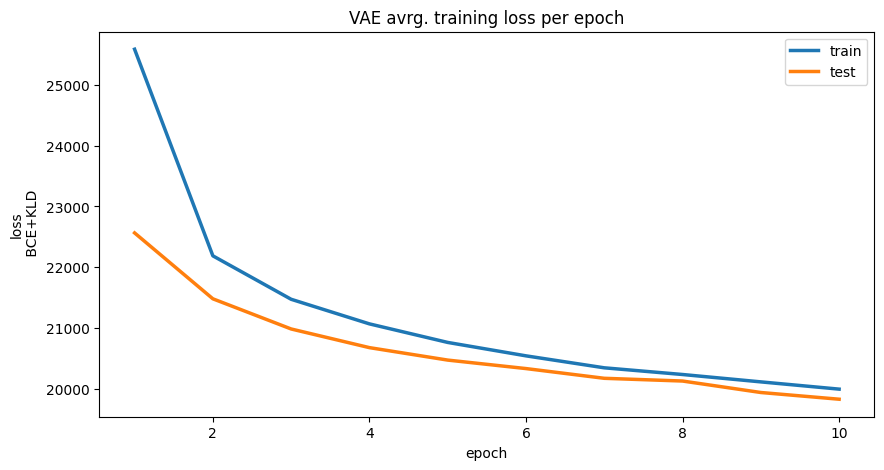

In [344]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [345]:
# encode entries
latent_coordinates = []
for data in X_train:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model.encode(torch.Tensor(data).to(device))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)


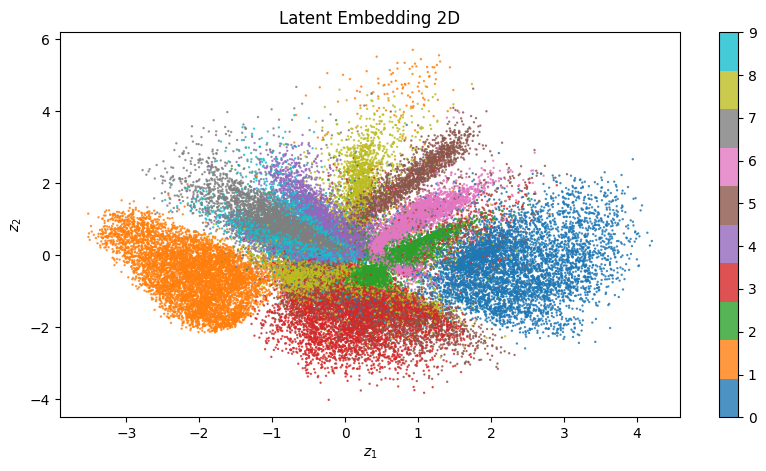

In [346]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=y_train, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

In [347]:
EPOCHS = 10
model_cb = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_cb.parameters(), lr=1e-3)

In [348]:
train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model_cb, epoch=e, train_loader=train_loader, loss=loss_cb)
    test_loss_vals = test(model_cb, epoch=e, test_loader=test_loader, loss=loss_cb)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=1088.299072265625
BCE=69594.015625 KLD=0.5139946937561035
Train epoch=1 [3200/60000]	 loss=929.61572265625
BCE=39764.3203125 KLD=26.382627487182617
Train epoch=1 [6400/60000]	 loss=925.866455078125
BCE=39377.3359375 KLD=60.53050231933594
Train epoch=1 [9600/60000]	 loss=922.29541015625
BCE=38686.63671875 KLD=107.37568664550781
Train epoch=1 [12800/60000]	 loss=915.9832153320312
BCE=37336.34375 KLD=138.6659698486328
Train epoch=1 [16000/60000]	 loss=919.525146484375
BCE=37883.60546875 KLD=216.9683074951172
Train epoch=1 [19200/60000]	 loss=915.6693115234375
BCE=37126.0078125 KLD=220.08717346191406
Train epoch=1 [22400/60000]	 loss=917.7555541992188
BCE=37450.4765625 KLD=212.71253967285156
Train epoch=1 [25600/60000]	 loss=917.4639892578125
BCE=37487.2421875 KLD=218.1559295654297
Train epoch=1 [28800/60000]	 loss=918.630859375
BCE=37821.13671875 KLD=239.81443786621094
Train epoch=1 [32000/60000]	 loss=913.2469482421875
BCE=36787.2421875 KLD=302.864501953125


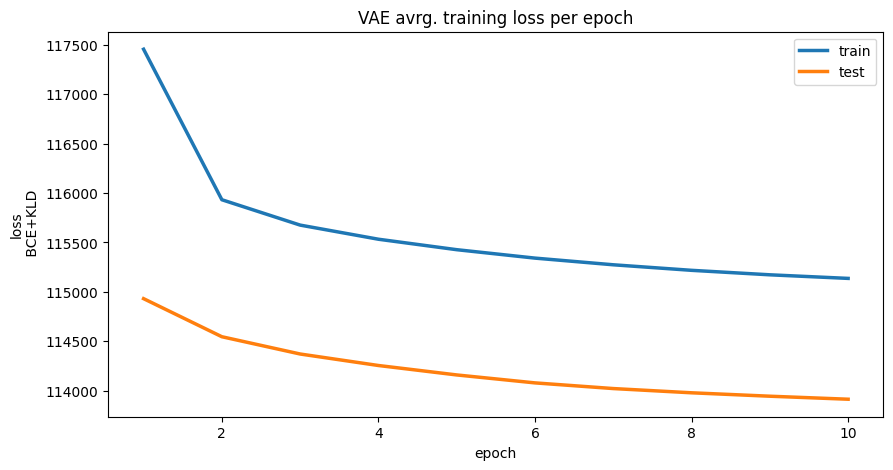

In [349]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [350]:
# encode entries
latent_coordinates = []
for data in X_train:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model_cb.encode(torch.Tensor(data).to(device))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)


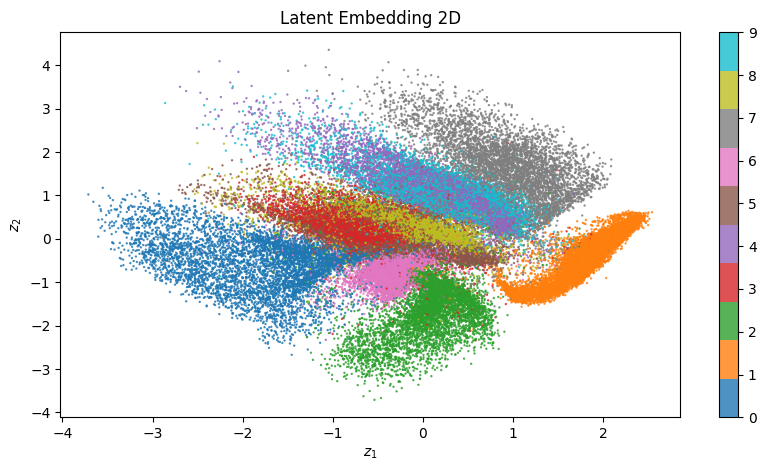

In [351]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=y_train, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

In [352]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)

torch.Size([144, 2])

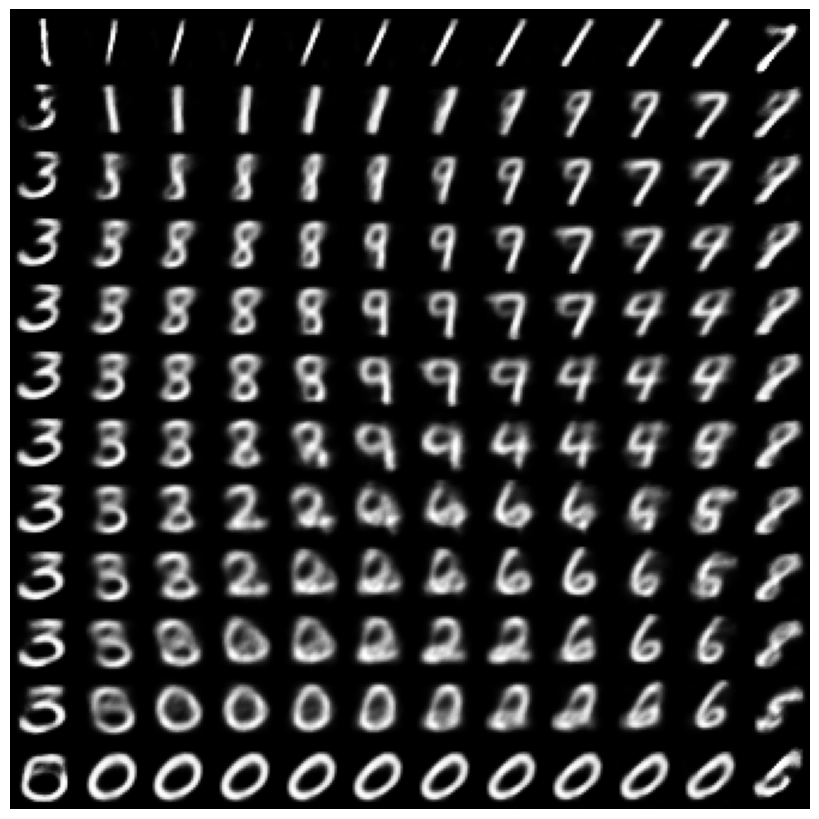

In [353]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))
lst2 = []

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = model.decode(_zz.to(device)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        lst2.append(img)
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()


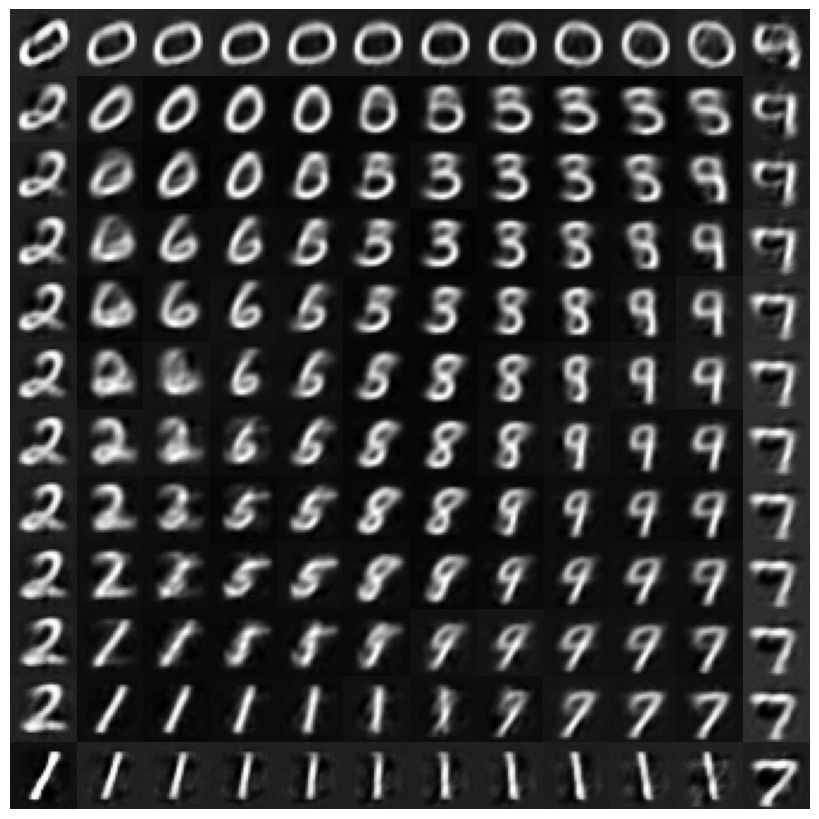

In [354]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))
lst = []

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = model_cb.decode(_zz.to(device)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        lst.append(img)
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()


In [355]:
def constant(lambda_, eps=1e-5):
    c = 2. * torch.arctanh(1. - 2. * lambda_) / (1. - 2. * lambda_)

    return c

def logConstant(x):
    if abs(x - 0.5) < 1e-3:
        val = torch.log(torch.tensor(2))
        v = 1. - 2. * x
        v_squared = v ** 2
        taylor = 1
        e = 1
        for i in range(1, 10):
            e *= v_squared
            taylor += e / (2. * i + 1)
        return val + torch.log(taylor)
    return torch.log(constant(x))

In [251]:
l = torch.tensor(0.499)
print(torch.log(constant(l)))
print(logConstant(l))

l = torch.tensor(0.5-1e-17)
print(torch.log(constant(l)))
print(logConstant(l))

tensor(0.6931)
tensor(0.6931)
tensor(nan)
tensor(0.6931)


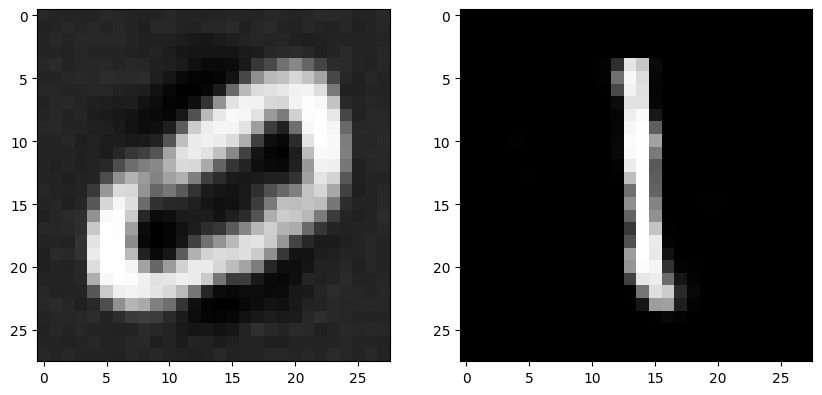

In [356]:
imm1 = lst[0]
imm2 = lst2[0]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(imm1, cmap='gray')
axarr[1].imshow(imm2, cmap='gray')

In [261]:
EPOCHS = 20
model_cb = VAE(hidden_dims=[300, 50, 20, 50, 300]) # NOTE: 20D latent space
optimizer = optim.Adam(model_cb.parameters(), lr=1e-3)

train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model_cb, epoch=e, train_loader=train_loader, loss=loss_cb)
    test_loss_vals = test(model_cb, epoch=e, test_loader=test_loader, loss=loss_cb)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=1089.484375
BCE=69794.0859375 KLD=18.405887603759766
Train epoch=1 [3200/60000]	 loss=928.1092529296875
BCE=40624.8984375 KLD=42.135963439941406
Train epoch=1 [6400/60000]	 loss=922.4707641601562
BCE=39123.890625 KLD=10.632840156555176
Train epoch=1 [9600/60000]	 loss=924.1903076171875
BCE=39014.28125 KLD=22.179534912109375
Train epoch=1 [12800/60000]	 loss=925.869873046875
BCE=39066.8359375 KLD=47.46232223510742
Train epoch=1 [16000/60000]	 loss=924.539306640625
BCE=38809.50390625 KLD=56.730106353759766
Train epoch=1 [19200/60000]	 loss=921.5707397460938
BCE=38760.05078125 KLD=95.21459197998047
Train epoch=1 [22400/60000]	 loss=919.1622314453125
BCE=37809.3671875 KLD=184.18589782714844
Train epoch=1 [25600/60000]	 loss=920.3008422851562
BCE=37987.09765625 KLD=214.84890747070312
Train epoch=1 [28800/60000]	 loss=916.0199584960938
BCE=36987.6484375 KLD=280.7978210449219
Train epoch=1 [32000/60000]	 loss=915.7933349609375
BCE=37273.19921875 KLD=250.749420166

In [271]:
lst = []
samples = torch.randn(64, 20)

samples = model_cb.decode(samples).cpu().detach().numpy()

for sample in samples:
    img = sample.reshape((28,28))
    lst.append(img)

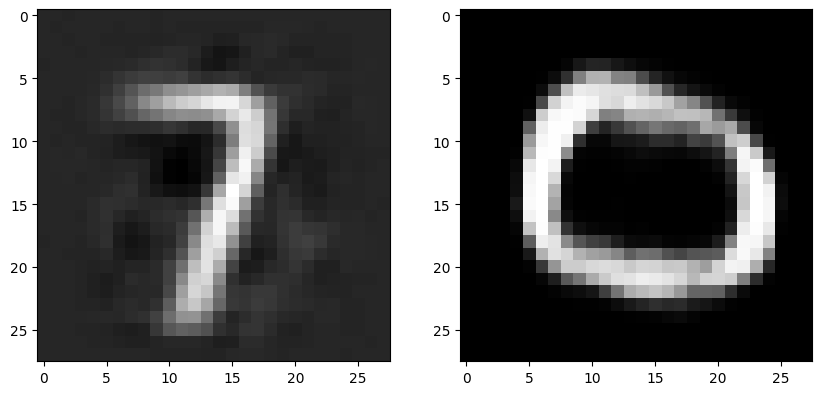

In [272]:
imm1 = lst[0]
imm2 = lst2[0]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(imm1, cmap='gray')
axarr[1].imshow(imm2, cmap='gray')

In [357]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=device):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        # dropout layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h1 = self.dropout1(h1)
        h2 = F.relu(self.enc_h(h1))
        h2 = self.dropout2(h2)
        return self.enc_mu(h2), F.softplus(self.enc_sigma(h2))

    def reparameterize(self, mu: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        # std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h3 = self.dropout3(h3)
        h4 = F.relu(self.dec_layer(h3))
        h4 = self.dropout4(h4)
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, std = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, std)
        return self.decode(z), mu, 2.*torch.log(std)

In [281]:
EPOCHS = 100
model_cb = VAE(hidden_dims=[500, 500, 20, 500, 500]) # NOTE: 20D latent space
optimizer = optim.Adam(model_cb.parameters(), lr=1e-3)

train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model_cb, epoch=e, train_loader=train_loader, loss=loss_cb)
    test_loss_vals = test(model_cb, epoch=e, test_loader=test_loader, loss=loss_cb)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=1090.2882080078125
BCE=69653.84375 KLD=278.68927001953125
Train epoch=1 [3200/60000]	 loss=925.4833374023438
BCE=39720.7421875 KLD=235.45358276367188
Train epoch=1 [6400/60000]	 loss=923.3193359375
BCE=38373.85546875 KLD=88.7221908569336
Train epoch=1 [9600/60000]	 loss=923.31103515625
BCE=38407.5546875 KLD=66.16864776611328
Train epoch=1 [12800/60000]	 loss=921.7850952148438
BCE=38384.37109375 KLD=53.70783615112305
Train epoch=1 [16000/60000]	 loss=920.28125
BCE=38183.09375 KLD=66.70510864257812
Train epoch=1 [19200/60000]	 loss=919.22509765625
BCE=37499.953125 KLD=166.52879333496094
Train epoch=1 [22400/60000]	 loss=917.5767822265625
BCE=37333.703125 KLD=241.98622131347656
Train epoch=1 [25600/60000]	 loss=914.2430419921875
BCE=36479.94921875 KLD=371.870849609375
Train epoch=1 [28800/60000]	 loss=914.5386962890625
BCE=36381.1953125 KLD=380.8676452636719
Train epoch=1 [32000/60000]	 loss=918.617919921875
BCE=36992.71484375 KLD=500.5673828125
Train epoch=1

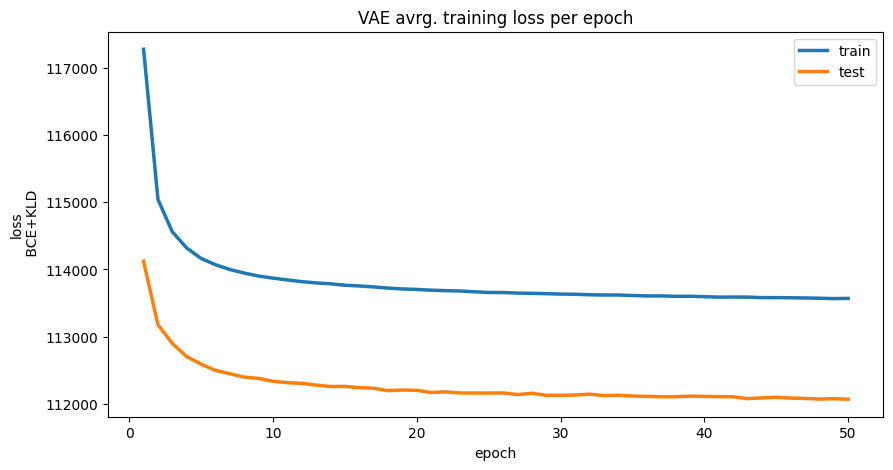

In [282]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [283]:
lst = []
samples = torch.randn(64, 20)

samples = model_cb.decode(samples).cpu().detach().numpy()

for sample in samples:
    img = sample.reshape((28,28))
    lst.append(img)

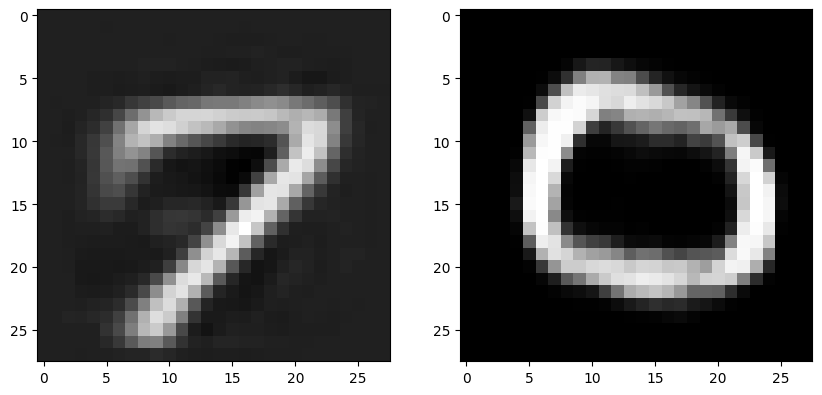

In [285]:
imm1 = lst[0]
imm2 = lst2[0]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(imm1, cmap='gray')
axarr[1].imshow(imm2, cmap='gray')